In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [44]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010])
# ])

# # convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


In [64]:
# loading the train data
batch_size = 128
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )


Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [46]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        # He Weight Initialization
        self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
        self.biases = torch.zeros((1, n_neurons))
        self.weights = self.weights.to(device)
        self.biases = self.biases.to(device)
    
    def forward(self, inputs):
        self.inputs = inputs
        self.inputs = self.inputs.to(device)
        return torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, output_error):
        # calculating errors
        self.inputs_error = torch.matmul(output_error, self.weights.T)
        self.inputs_error = self.inputs_error.to(device)
        self.weights_grad = torch.matmul(self.inputs.T, output_error)
        self.weights_grad = self.weights_grad.to(device)
        self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
        self.biases_grad =  self.biases_grad.to(device)
        return self.inputs_error


### Activation Layers


In [47]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        return torch.maximum(torch.zeros_like(inputs), inputs)

    def backward(self, output_error):
        self.inputs_error = output_error.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[self.inputs <= 0] = 0
        return self.inputs_error


In [48]:
class Sigmoid:
    def forward(self,inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        self.outputs.to(device)
        return self.outputs

    def backward(self,output_error):
        self.outputs_grad = output_error * (1-self.outputs) * self.outputs
        self.outputs_grad = self.outputs_grad.to(device)
        return self.outputs_grad

In [49]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
        exp_inputs = exp_inputs.to(device)
        self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
        self.outputs = self.outputs.to(device)
        return self.outputs



### Loss function

In [50]:
class Categorical_Cross_Entropy_loss:
    
    def forward(self, softmax_output, class_label):
        # Apply softmax function to the output
        self.softmax_output = torch.clamp(softmax_output, 1e-12, 1. - 1e-12)
        self.softmax_output = self.softmax_output.to(device)
        N = softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = torch.zeros_like(softmax_output)
        self.class_label = self.class_label.to(device)
        self.class_label[torch.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -torch.sum(self.class_label * torch.log(self.softmax_output)) / N
        self.loss = self.loss.to(device)
        return self.loss
    
    def backward(self, class_label):
        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.inputs_error = self.softmax_output.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[torch.arange(N), class_label] -= 1
        self.inputs_error = self.inputs_error / N
        return self.inputs_error


### Optimizer

In [51]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.001):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        #self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

In [52]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate=learning_rate
        self.scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=learning_rate)
    
    def __call__(self, layer, num_epoch):
        device = layer.weights.device
        layer.weights = layer.weights.to(device)
        layer.biases = layer.biases.to(device)
        layer.weights -= self.scheduler(num_epoch) * layer.weights_grad.to(device)
        layer.biases -= self.scheduler(num_epoch) * layer.biases_grad.to(device)


### Architecture

In [53]:
feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
#model
Layer1 = Dense(num_features,20)
Act1 = ReLU()
Layer2 = Dense(20,10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD(learning_rate=0.001)

### Train

In [55]:


epochs = 20

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train)

        # Report batch metrics
        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()

        # Backward pass
        x = Loss.backward(y_train)
        #x = Act2.backward(x)
        x = Layer2.backward(x)
        x = Act1.backward(x)
        x = Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1, epoch)
        Optimizer(Layer2, epoch)

    # Report epoch metrics
    epoch_loss /= len(train_dataloader)
    epoch_accuracy /= len(train_dataloader)
    print(f'Epoch: {epoch+1}')
    print(f'Loss: {epoch_loss:.7f}')
    print(f'Accuracy: {epoch_accuracy:.7f}')
    print('--------------------------')


Epoch 1: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


Epoch: 1
Loss: 2.3791843
Accuracy: 0.1513707
--------------------------


Epoch 2: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch: 2
Loss: 2.0902419
Accuracy: 0.2642703
--------------------------


Epoch 3: 100%|██████████| 391/391 [01:46<00:00,  3.67it/s]


Epoch: 3
Loss: 1.8448858
Accuracy: 0.3579923
--------------------------


Epoch 4: 100%|██████████| 391/391 [01:54<00:00,  3.42it/s]


Epoch: 4
Loss: 1.6127355
Accuracy: 0.4471068
--------------------------


Epoch 5: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch: 5
Loss: 1.4343063
Accuracy: 0.5150176
--------------------------


Epoch 6: 100%|██████████| 391/391 [01:47<00:00,  3.63it/s]


Epoch: 6
Loss: 1.3053009
Accuracy: 0.5585838
--------------------------


Epoch 7: 100%|██████████| 391/391 [01:53<00:00,  3.45it/s]


Epoch: 7
Loss: 1.2098555
Accuracy: 0.5930227
--------------------------


Epoch 8: 100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


Epoch: 8
Loss: 1.1327674
Accuracy: 0.6190937
--------------------------


Epoch 9: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch: 9
Loss: 1.0716370
Accuracy: 0.6404412
--------------------------


Epoch 10: 100%|██████████| 391/391 [01:56<00:00,  3.36it/s]


Epoch: 10
Loss: 1.0205224
Accuracy: 0.6554388
--------------------------


Epoch 11: 100%|██████████| 391/391 [01:53<00:00,  3.44it/s]


Epoch: 11
Loss: 0.9786209
Accuracy: 0.6691616
--------------------------


Epoch 12: 100%|██████████| 391/391 [02:12<00:00,  2.95it/s]


Epoch: 12
Loss: 0.9427479
Accuracy: 0.6806466
--------------------------


Epoch 13: 100%|██████████| 391/391 [01:47<00:00,  3.62it/s]


Epoch: 13
Loss: 0.9114855
Accuracy: 0.6921915
--------------------------


Epoch 14: 100%|██████████| 391/391 [01:46<00:00,  3.66it/s]


Epoch: 14
Loss: 0.8868643
Accuracy: 0.6993886
--------------------------


Epoch 15: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch: 15
Loss: 0.8635906
Accuracy: 0.7064138
--------------------------


Epoch 16: 100%|██████████| 391/391 [02:08<00:00,  3.05it/s]


Epoch: 16
Loss: 0.8437336
Accuracy: 0.7130715
--------------------------


Epoch 17: 100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch: 17
Loss: 0.8282540
Accuracy: 0.7185742
--------------------------


Epoch 18: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch: 18
Loss: 0.8097857
Accuracy: 0.7244325
--------------------------


Epoch 19: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch: 19
Loss: 0.7960588
Accuracy: 0.7265465
--------------------------


Epoch 20: 100%|██████████| 391/391 [01:55<00:00,  3.38it/s]


Epoch: 20
Loss: 0.7880922
Accuracy: 0.7308704
--------------------------


### Test

In [65]:
test_loss = 0
test_accuracy = 0
for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
        # Forward pass
        x_test, y_test = x_test.to(device), y_test.to(device)
        x = feature_extractor(x_test)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_test)

        # Report batch metrics
        y_predict_test = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_test == y_predict_test).float())
        test_loss += loss.item()
        test_accuracy += accuracy.item()
        
test_loss /= len(test_dataloader)
test_accuracy /= len(test_dataloader)
print(f'Test Loss: {test_loss:.7f}')
print(f'Test Accuracy: {test_accuracy:.7f}')

   

Testing: 100%|██████████| 79/79 [00:20<00:00,  3.85it/s]

Test Loss: 0.7930434
Test Accuracy: 0.7319027


### Evaluation

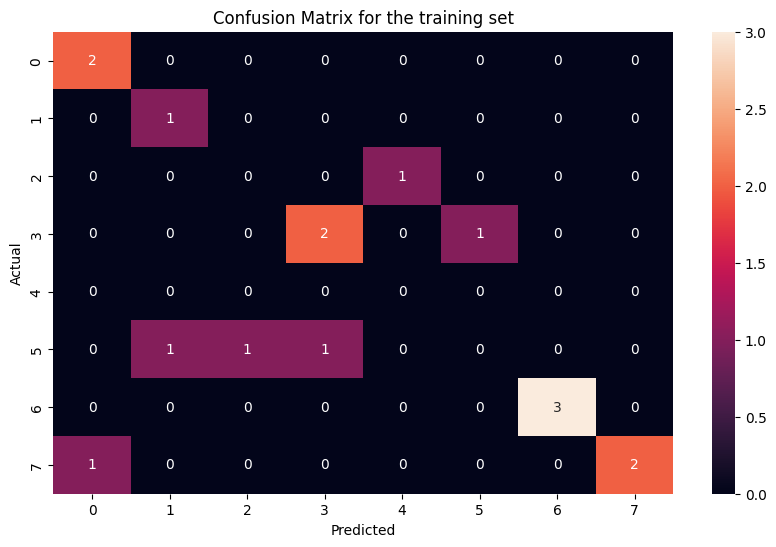

In [63]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predict_train.data.cpu().numpy()
y_train_numpy = y_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_pred_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()

#Confusion Matrix for the test set
y_predts_numpy = y_predict_test.data.cpu().numpy()
y_test_numpy = y_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()